In [1]:
import torch
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vectors
import pandas as pd
import time
import numpy as np
import torch.nn.functional as TF
import matplotlib.pyplot as plt
import copy

In [2]:
# Load pretrained model from Tencent
from gensim.models import KeyedVectors

#100-dim file
wv_from_text = KeyedVectors.load_word2vec_format("tencent-ailab-embedding-zh-d100-v0.2.0-s.txt", binary=False)

In [4]:
# Define inputs for the model

# vocab contains all the Chinese words in the dataset
vocab         = wv_from_text.index_to_key
vocab_size    = len(vocab)
print("The first 10 words in the vocabulary are:", vocab[:10])

# word_to_index is the map between Chinese words and its indeces {'的'：3}
word_to_index = wv_from_text.key_to_index
print("The index for the Chinese word '的' is:", word_to_index['的'])

# The classic example works for this pretrained model
classic = wv_from_text.most_similar(positive=['女人', '国王'], negative=['男人'], topn=1)
print(classic[0], "queen = (king国王 - man男人) + woman女人")

The first 10 words in the vocabulary are: ['</s>', '，', ',', '的', '。', '、', '了', '：', '“', '”']
The index for the Chinese word '的' is: 3
('王后', 0.8768935799598694) queen = (king国王 - man男人) + woman女人


In [5]:
# Define dataset to load to dataloader
class TrainData(Dataset):
    
    def __init__(self, trained_data):
        """Loads the data from the pretrained model"""
        self.data = trained_data

    def __getitem__(self, idx):
        """Returns the datapoint at a given index"""
        return self.data[idx]
    
    def __len__(self):
        """Returns the number of datapoints in the dataset"""
        return len(self.data)

In [6]:
# Define collate_batch for batch of training samples

def wordToindex(word):
    """Get the corresponding index for the Chinese word"""
    return word_to_index[word]

def collate_batch(batch):
    """Converts a batch of data into packed PyTorch tensor format, 
    and collates the results by index, word, and one-hot vector 
    for use in an Autoencoder.
    """
    # Initialize lists that separate out the 3 components
    index_list      = list()
    word_list       = list()
    
    for word in batch:
        # Convert to PyTorch format
        index   = wordToindex(word)
        
        # Add converted data to separate component lists
        index_list.append(index)
        word_list.append(word)
    
    # Convert to mini-batch tensors
    index_tensor = torch.tensor(index_list, dtype=torch.int64)
    
    return (word_list, index_tensor)

In [7]:
import time
import math
# To keep track of training time
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Text(0.5, 1.0, 'Cosine Scheduler')

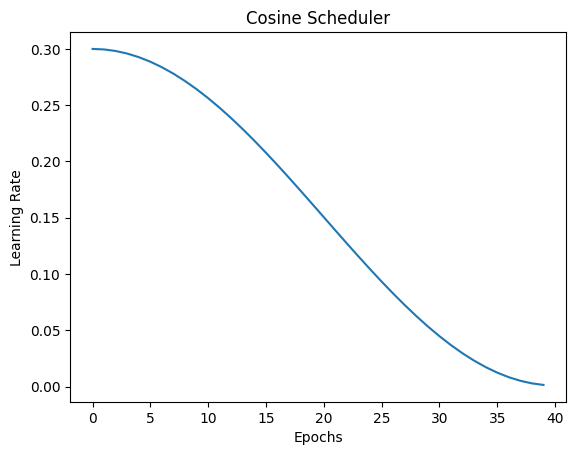

In [8]:
# Used for weight decay
# Credit: https://d2l.ai/chapter_optimization/lr-scheduler.html
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=40, base_lr=0.3, final_lr=0.001)
num_epochs = 40
sch = [scheduler(t) for t in range(num_epochs)]
xtrain = np.arange(num_epochs)
plt.plot(xtrain, sch)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Cosine Scheduler")


## Tying Weight Autoencoder

In [9]:
class ZhZhAutoencoderTW(nn.Module):
    """
    Autoencoder to learn the weights connecting Chinese 
    embeddings back to one-hot vectors. Initialize the 
    weights connecting the embeddings and one-hot vectors 
    with the transpose of the weights from the Tecent 
    pretrained model, connecting the one-hot vector and
    embedding, to speed up training.
    """
    def __init__(self, pretrained, vocab):
        super(ZhZhAutoencoderTW, self).__init__()
        
        # Save the pretrained embedding within the model
        # load pretrained embeddings and freeze them
        self.weights    = torch.FloatTensor(pretrained.vectors) 
        self.encoder    = nn.Embedding.from_pretrained(self.weights, freeze = True)
        
        # Make a copy of the pretrained weights and use them in the following layers
        copy_pretrained = copy.deepcopy(pretrained)
        self.copyweight = torch.FloatTensor(copy_pretrained.vectors) 
        self.decoder    = nn.Parameter(self.copyweight.t()) 
        self.vocab      = vocab

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the embeddings for text
        trained_embed = self.encoder(text)
        
        # Turn embedding back to one-hot
        one_hot       = trained_embed @ self.decoder 
        
        return one_hot

In [10]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# Instantiate the model
model1 = ZhZhAutoencoderTW(wv_from_text, vocab).to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.3)

Using cuda device


In [11]:
# Define mini-batch
# bacth size = powers of 2
batch_size = 256
train_data = TrainData(vocab) 
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           collate_fn=collate_batch)

In [ ]:
# Training
num_epochs = 40
avg_loss = []
losses = 0
start = time.time()
print("Start Batch Size =", batch_size, file=open('wt.txt', 'a'))
for epoch in range(num_epochs):
    losses = 0
    for i, (word, index) in enumerate(train_loader):
        # Clear gradients w.r.t. parameters
        optimizer1.zero_grad()
        
        index = index.to(device) 
        
        # Forward pass to get output/logits
        outputs_train = model1(index)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs_train, index)
        losses += loss.item()
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer1.step()
    avg = losses / vocab_size
    avg_loss.append(avg)
    
    for param_group in optimizer1.param_groups:
        param_group['lr'] = scheduler(epoch)
        print("Learning rate is now", param_group['lr'], file=open('wt.txt', 'a'))
    
    print('%s (%d %d%%) %.15f' % (timeSince(start), epoch, epoch / num_epochs * 100, avg), file=open('wt.txt', 'a'))
    torch.save(model1.state_dict(), '/mldata/jingyi_wu/ling111_project_wt.pt')
            
print("Finish training!", file=open('wt.txt', 'a'))

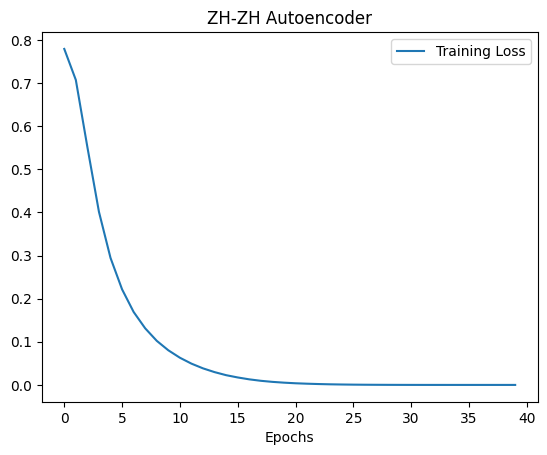

In [13]:
xtrain = np.arange(40)
plt.plot(xtrain, avg_loss, label = "Training Loss")
plt.xlabel("Epochs")
plt.title("ZH-ZH Autoencoder")
plt.legend()

In [14]:
# save the losses in the pickle file
import pickle  
with open('avg_loss.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(avg_loss, file)

In [15]:
# load the losses to the pickle file
with open('avg_loss.pkl', 'rb') as file:
      
    # Call load method to deserialze
    avg_loss_load = pickle.load(file)
  
    print(avg_loss_load)

[0.7789218018393517, 0.7070050383987426, 0.5512636870574951, 0.4012208203601837, 0.294452887503624, 0.22156028043746948, 0.16912142067050934, 0.13118417722654344, 0.10219273711013795, 0.0802863381280899, 0.06305262226676941, 0.04932719606733322, 0.038380917043447496, 0.029683953050136568, 0.022581880205571652, 0.017307459743216635, 0.012927948986083269, 0.009560800730894378, 0.007087606992136743, 0.005238926924867748, 0.0038244752912138923, 0.0028201018688295324, 0.0020217011630273975, 0.0014109165025996248, 0.0009763571204434946, 0.0006501101044120713, 0.0004316201922142459, 0.0002818315903746755, 0.0001735398575777612, 9.965590946405221e-05, 5.19046124722147e-05, 2.433470795029184e-05, 1.084297876956509e-05, 4.2288043586306796e-06, 1.6077211017657183e-06, 3.5141290262044966e-07, 4.811883108037924e-08, 3.90080782789308e-09, 4.716174040540755e-11, 4.510735168691826e-11]


## Let's test the model prediction a bit

In [16]:
# load the weights to the zhzhautoencoder
model_weight = torch.load('/mldata/jingyi_wu/ling111_project_wt.pt')
model1.load_state_dict(model_weight)


<All keys matched successfully>

In [17]:
# Get a single sample
batch_size = 1
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           collate_fn=collate_batch)

In [18]:
test = next(iter(train_loader))
print("Random word:", test[0])
pos = torch.argmax(model1(test[1].to(device)))
print("Model prediction:", vocab[pos])

Random word: ['浙江大部']
Model prediction: 浙江大部


In [19]:
test = next(iter(train_loader))
print("Random word:", test[0])
pos = torch.argmax(model1(test[1].to(device)))
print("Model prediction:", vocab[pos])

Random word: ['姚晶晶']
Model prediction: 姚晶晶
